# Analyzing behavior-only sessions from the Visual Behavior Neuropixels dataset

In addition to the behavior sessions that accompany Neuropixels recordings, we have also released the training sessions for each mouse as standalone NWB files.

The following tutorial will demonstrate how to load these sessions for an example mouse. We'll cover the following topics:

* <a href='#Finding-behavior-sessions-to-analyze'>Finding behavior sessions to analyze</a>
* <a href='#Loading-behavior-data'>Loading behavior data</a>
* <a href='#Understanding-behavior-session-contents'>Understanding the behavior session contents</a>


This tutorial assumes you've already created a data cache, or are working with the files on AWS. If you haven't reached that step yet, we recommend going through the [data access tutorial](https://allensdk.readthedocs.io/en/latest/visual_behavior_neuropixels.html) first.

You can read more about the stages of behavioral training in the [white paper](https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/f7/06/f706855a-a3a1-4a3a-a6b0-3502ad64680f/visualbehaviorneuropixels_technicalwhitepaper.pdf) accompanying this release

## Finding behavior sessions to analyze

First let's import the `VisualBehaviorNeuropixelsProjectCache` as well as a few other helpful packages.

In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = "/path/to/vbn_cache"

Now we'll instantiate the cache to begin downloading data from the S3 bucket. Note that the `cache_dir` should point to a local directory where you would like to download the data. If you've already downloaded the required data, the cache will pull the local files from this directory.

In [4]:
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=output_dir)

/home/runner/work/AllenSDK/AllenSDK/allensdk/api/cloud_cache/cloud_cache.py:439: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. You might want to consider running

VisualBehaviorNeuropixelsProjectCache.construct_local_manifest()

to avoid needlessly downloading duplicates of data files that did not change between data releases. NOTE: running this method will require hashing every data file you have currently downloaded and could be very time consuming.

To avoid this warning in the future, make sure that

/tmp/tmp5i5jve39/_downloaded_data.json

is not deleted between instantiations of this cache
  warnings.warn(msg, MissingLocalManifestWarning)
ecephys_sessions.csv: 100%|██████████| 64.7k/64.7k [00:00<00:00, 452kMB/s] 
behavior_sessions.csv: 100%|██████████| 562k/562k [00:00<00:00, 3.04MMB/s] 
units.csv: 100%|██████████| 132M/132M [00:05<00:00, 23.2MMB/s]
probes.csv: 100%|██████████| 130k/130k [00:00<00:00,

Once we have a cache instance, we can grab the `behavior_session_table` to see what behavior sessions are available for analysis.

In [5]:
behavior_session_table = cache.get_behavior_session_table()
behavior_session_table.head()

equipment_name  \
behavior_session_id                  
1055198750                    NP.1   
1052162513                    NP.1   
1056100734                    NP.1   
1055397049                    NP.1   
1052162543                    NP.1   

                                                          genotype  mouse_id  \
behavior_session_id                                                            
1055198750                                                   wt/wt    531237   
1052162513           Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    530862   
1056100734                                                   wt/wt    531237   
1055397049                                                   wt/wt    531237   
1052162543                                                   wt/wt    533537   

                    sex  age_in_days  session_number  \
behavior_session_id                                    
1055198750            F          158              45   
1052162513            M          143              41   
1056100734            F          163              48   
1055397049            F          159              46   
1052162543            M          128              30   

                     prior_exposures_to_session_type  \
behavior_session_id                                    
1055198750                                         5   
1052162513                                         2   
1056100734                                         8   
1055397049                                         6   
1052162543                                         0   

                     prior_exposures_to_image_set  \
behavior_session_id                                 
1055198750                                     38   
1052162513                                     29   
1056100734                                     41   
1055397049                                     39   
1052162543                                     23   

                     prior_exposures_to_omissions  ecephys_session_id  \
behavior_session_id                                                     
1055198750                                      0          1055182255   
1052162513                                      0          1051331372   
1056100734                                      0          1056089509   
1055397049                                      0          1055386631   
1052162543                                      0          1052096186   

                                  date_of_acquisition  \
behavior_session_id                                     
1055198750           2020-10-07 09:40:30.407000+00:00   
1052162513           2020-09-18 10:18:25.503000+00:00   
1056100734           2020-10-12 12:31:57.133000+00:00   
1055397049           2020-10-08 10:46:16.623000+00:00   
1052162543           2020-09-22 10:54:33.351000+00:00   

                                                        session_type  \
behavior_session_id                                                    
1055198750           HABITUATION_5_images_G_handoff_ready_3uL_reward   
1052162513           HABITUATION_5_images_G_handoff_ready_3uL_reward   
1056100734           HABITUATION_5_images_G_handoff_ready_3uL_reward   
1055397049           HABITUATION_5_images_G_handoff_ready_3uL_reward   
1052162543           HABITUATION_5_images_G_handoff_ready_5uL_reward   

                    image_set  file_id  
behavior_session_id                     
1055198750                  G     1022  
1052162513                  G     1023  
1056100734                  G     1024  
1055397049                  G     1025  
1052162543                  G     1026

Now let's grab all the sessions for an example mouse (533537) and order them chronologically.

In [6]:
mouse_id = 533537
mouse_session_table = behavior_session_table[behavior_session_table['mouse_id']==mouse_id].sort_values(by='date_of_acquisition')
mouse_session_table

equipment_name genotype  mouse_id sex  age_in_days  \
behavior_session_id                                                      
1041490591              BEH.G-Box2    wt/wt    533537   M           82   
1042048852              BEH.G-Box6    wt/wt    533537   M           85   
1042325912              BEH.G-Box1    wt/wt    533537   M           86   
1042593405              BEH.G-Box2    wt/wt    533537   M           87   
1042812152              BEH.G-Box6    wt/wt    533537   M           88   
1043131651              BEH.G-Box6    wt/wt    533537   M           89   
1043758309              BEH.G-Box6    wt/wt    533537   M           92   
1044600724              BEH.G-Box6    wt/wt    533537   M           95   
1044996732              BEH.G-Box6    wt/wt    533537   M           96   
1045550754              BEH.G-Box4    wt/wt    533537   M           99   
1045904194              BEH.G-Box4    wt/wt    533537   M          100   
1046247654              BEH.G-Box4    wt/wt    533537   M          101   
1046638304              BEH.G-Box3    wt/wt    533537   M          102   
1046925699              BEH.G-Box3    wt/wt    533537   M          103   
1047535739              BEH.G-Box3    wt/wt    533537   M          106   
1047772100              BEH.G-Box3    wt/wt    533537   M          107   
1048001337              BEH.G-Box3    wt/wt    533537   M          108   
1048222926              BEH.G-Box3    wt/wt    533537   M          109   
1048430639              BEH.G-Box3    wt/wt    533537   M          110   
1049116555              BEH.G-Box3    wt/wt    533537   M          114   
1049302025              BEH.G-Box3    wt/wt    533537   M          115   
1049536543              BEH.G-Box3    wt/wt    533537   M          116   
1049778048              BEH.G-Box3    wt/wt    533537   M          117   
1050311775              BEH.G-Box3    wt/wt    533537   M          120   
1050668465              BEH.G-Box3    wt/wt    533537   M          121   
1050968995              BEH.G-Box3    wt/wt    533537   M          122   
1051180953              BEH.G-Box3    wt/wt    533537   M          123   
1051380286              BEH.G-Box3    wt/wt    533537   M          124   
1051943283              BEH.G-Box3    wt/wt    533537   M          127   
1052162543                    NP.1    wt/wt    533537   M          128   
1052316794                    NP.1    wt/wt    533537   M          129   
1052547131                    NP.1    wt/wt    533537   M          130   
1052772626                    NP.1    wt/wt    533537   M          131   
1053320526                    NP.1    wt/wt    533537   M          134   
1053566897                    NP.1    wt/wt    533537   M          135   
1053736353                    NP.1    wt/wt    533537   M          136   
1053932834                    NP.1    wt/wt    533537   M          137   
1054166851                    NP.1    wt/wt    533537   M          138   
1054753938                    NP.1    wt/wt    533537   M          141   
1055021129                    NP.1    wt/wt    533537   M          142   
1055253879                    NP.1    wt/wt    533537   M          143   
1055431030                    NP.1    wt/wt    533537   M          144   

                     session_number  prior_exposures_to_session_type  \
behavior_session_id                                                    
1041490591                        1                                0   
1042048852                        2                                0   
1042325912                        3                                1   
1042593405                        4                                2   
1042812152                        5                                0   
1043131651                        6                                1   
1043758309                        7                                0   
1044600724                        8                                1   
1044996732                        9        

In [7]:
len(mouse_session_table)

42

Looks like this mouse had 42 behavior sessions. You can see that these start with the earliest training stage (TRAINING_0), when the mouse is first introduced to the lick spout. After that, the mouse progresses through the training stages and is handed off to the Neuropixels team for habituation on the experimental rig on 2020-09-22. The final two sessions in this list are recording sessions (EPHYS_1) during which Neuropixels data was collected while the mouse performed the behavior. If we wanted to analyze the ephys data from these sessions, we would use the `ecephys_session_id` from this table to load the corresponding NWB file with `cache.get_ecephys_session`.

## Loading behavior data

Now that we've identified a few behavior sessions of interest, let's download one for further analysis using the `behavior_session_id` from the table above and the `get_behavior_session` method of the cache. If you haven't already downloaded this data, the following line will download it from the S3 bucket to your local cache directory:

In [8]:
behavior_session = cache.get_behavior_session(1052316794)

behavior_session_1052316794.nwb: 100%|██████████| 188M/188M [00:08<00:00, 22.1MMB/s]
/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


We can view all of the attributes of this new object:

In [9]:
behavior_session.list_data_attributes_and_methods()

['behavior_session_id',
 'eye_tracking',
 'eye_tracking_rig_geometry',
 'get_performance_metrics',
 'get_reward_rate',
 'get_rolling_performance_df',
 'licks',
 'metadata',
 'raw_running_speed',
 'rewards',
 'running_speed',
 'stimulus_presentations',
 'stimulus_templates',
 'stimulus_timestamps',
 'task_parameters',
 'trials']

Note that any attribute can be followed by a `?` in a Jupyter Notebook to see the docstring. For example, running the cell below will make a frame appear at the bottom of your browser with the docstring for the `running_speed` attribute.

In [10]:
behavior_session.running_speed?

We can also look at some basic task parameters:

In [11]:
behavior_session.task_parameters

{'auto_reward_volume': 0.005,
 'blank_duration_sec': [0.5, 0.5],
 'image_set': 'images_G',
 'n_stimulus_frames': 72054,
 'omitted_flash_fraction': nan,
 'response_window_sec': [0.15, 0.75],
 'reward_volume': 0.005,
 'session_type': 'HABITUATION_5_images_G_handoff_ready_5uL_reward',
 'stimulus': 'images',
 'stimulus_distribution': 'geometric',
 'stimulus_duration_sec': 0.25,
 'stimulus_name': None,
 'task': 'change detection'}

## Understanding behavior session contents

Now that we've grabbed a session, let's take a look at a few of its attributes in more detail:

### Stimuli
A pandas dataframe with one row for every distinct stimulus describing what was shown and when it was presented to the mouse.

In [12]:
stimulus_presentations = behavior_session.stimulus_presentations
stimulus_presentations.head(5)

stimulus_block  image_index image_name  duration  \
stimulus_presentations_id                                                     
0                                       0            0    im036_r  0.250247   
1                                       0            0    im036_r  0.250204   
2                                       0            0    im036_r  0.250225   
3                                       0            0    im036_r  0.250249   
4                                       0            0    im036_r  0.250260   

                           start_time  end_time  start_frame  end_frame  \
stimulus_presentations_id                                                 
0                            1.021993  1.272240           60         75   
1                            1.772656  2.022860          105        120   
2                            2.523272  2.773497          150        165   
3                            3.273877  3.524126          195        210   
4                            4.024551  4.274811          240        255   

                           is_change  is_image_novel  omitted  \
stimulus_presentations_id                                       
0                              False           False    False   
1                              False           False    False   
2                              False           False    False   
3                              False           False    False   
4                              False           False    False   

                           flashes_since_change  trials_id  active  \
stimulus_presentations_id                                            
0                                             0          0    True   
1                                             1          0    True   
2                                             2          0    True   
3                                             3          0    True   
4                                             4          0    True   

                           is_sham_change  \
stimulus_presentations_id                   
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

                                                         stimulus_name  
stimulus_presentations_id                                               
0                          Natural_Images_Lum_Matched_set_ophys_G_2019  
1                          Natural_Images_Lum_Matched_set_ophys_G_2019  
2                          Natural_Images_Lum_Matched_set_ophys_G_2019  
3                          Natural_Images_Lum_Matched_set_ophys_G_2019  
4                          Natural_Images_Lum_Matched_set_ophys_G_2019

Here's a quick explanation for the important columns in this table:

`stimulus_name`: Indicates the stimulus category for this stimulus presentation. 

`duration`: Duration of stimulus in seconds

`start_time`: Experiment time when stimulus started. This value is corrected for display lag and therefore indicates when the stimulus actually appeared on the screen.

`end_time`: Experiment time when stimulus ended, also corrected for display lag.

`start_frame`: Stimulus frame index when this stimulus started. This can be used to sync this table to the behavior trials table, for which behavioral data is collected every frame.

`end_frame`: Stimulus frame index when this stimulus ended.

`flashes_since_change`: Indicates how many flashes of the same image have occurred since the last stimulus change.

`image_name`: Indicates which natural image was flashed for this stimulus presentation. To see how to visualize this image, check out [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_neuropixels_data_access.html).

`is_change`: Indicates whether the image identity changed for this stimulus presentation. When both this value and 'active' are TRUE, the mouse was rewarded for licking within the response window.

`omitted`: Indicates whether the image presentation was omitted for this flash. Most image flashes had a 5% probability of being omitted (producing a gray screen). Flashes immediately preceding a change or immediately following an omission could not be omitted.

`is_image_novel`: Indicates whether this image has been shown to the mouse in previous training sessions. If `True`, then this image is novel to the mouse.

### Licks
A pandas dataframe with one row for every detected lick onset time. For behavior-only sessions, licks times were not recorded on an independent DAQ. Instead, each lick is assigned the time of the stimulus frame during which it occurred.

In [13]:
behavior_session.licks.sample(5, random_state=42)

timestamps  frame
139     75.180928   4507
864    724.770382  43444
291    248.912996  14922
1242  1114.687610  66819
599    507.000650  30392

### Rewards
A pandas dataframe with one row for every reward that was delivered, assigned the time of the corresponding visual stimulus frame. `Autorewarded` is True if the reward was delivered without requiring a preceding lick.

In [14]:
behavior_session.rewards.sample(5, random_state=42)

volume   timestamps  auto_rewarded
68    0.005  1306.234934          False
108   0.005  2174.928880          False
31    0.005   540.779549          False
51    0.005   903.206528          False
95    0.005  1871.619053          False

### Running data
A pandas dataframe with one row for each read of the analog input line monitoring the encoder voltage, polled at ~60 Hz

In [15]:
behavior_session.running_speed.head()

timestamps      speed
0    0.000000   0.064051
1    0.016644   6.003349
2    0.033363  11.664898
3    0.050056  16.788652
4    0.066662  21.144286

### Now we can make a simple plot where we combine running, licking and stimuli for an example stretch of the session.

#### First, add a column to the stimulus_presentations table that assigns a unique color to every stimulus

In [16]:
unique_stimuli = [stimulus for stimulus in behavior_session.stimulus_presentations['image_name'].unique()]
colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}

stim_colors = stimulus_presentations.apply(lambda row: colormap[row['image_name']], axis=1)
stimulus_presentations['color'] = stim_colors

#### now make some simple plotting functions to plot these datastreams

In [17]:
def plot_running(ax, initial_time, final_time):
    '''
    a simple function to plot running speed between two specified times on a specified axis
    inputs:
        ax: axis on which to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    running_sample = behavior_session.running_speed.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        running_sample['timestamps'],
        running_sample['speed']
    )

def plot_licks(ax, initial_time, final_time):
    '''
    a simple function to plot licks as dots between two specified times on a specified axis
    inputs:
        ax: axis on which to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    licking_sample = behavior_session.licks.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        licking_sample['timestamps'],
        np.zeros_like(licking_sample['timestamps']),
        marker = 'o',
        color = 'black',
        linestyle = 'none'
    )
    
def plot_rewards(ax, initial_time, final_time):
    '''
    a simple function to plot rewards between two specified times as blue diamonds on a specified axis
    inputs:
        ax: axis on which to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    rewards_sample = behavior_session.rewards.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        rewards_sample['timestamps'],
        np.zeros_like(rewards_sample['timestamps']),
        marker = 'd',
        color = 'blue',
        linestyle = 'none',
        markersize = 12,
        alpha = 0.5
    )
    
def plot_stimuli(ax, ti, tf):
    '''
    a simple function to plot stimuli as colored vertical spans on a s
    inputs:
        ax: axis on which to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    stimulus_presentations_sample = stimulus_presentations.query('end_time >= @initial_time and start_time <= @final_time')
    for idx, stimulus in stimulus_presentations_sample.iterrows():
        ax.axvspan(stimulus['start_time'], stimulus['end_time'], color=stimulus['color'], alpha=0.25)

#### Now make the plot

<Figure size 640x480 with 0 Axes>

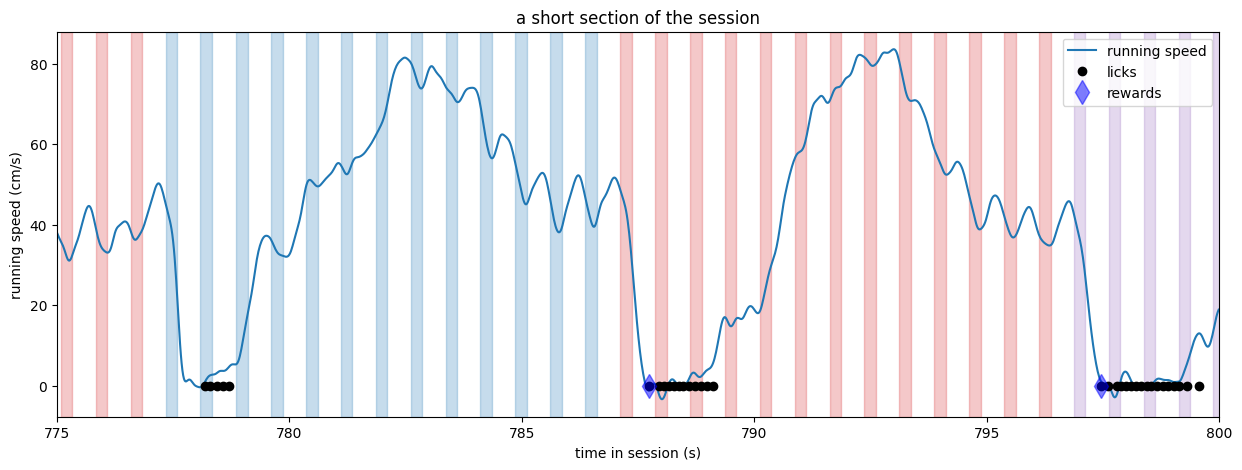

In [18]:
initial_time = 775 # initial time for plot, in seconds
final_time = 800 # final time for plot, in seconds

plt.clf()
fig, ax = plt.subplots(figsize = (15,5))
plot_running(ax, initial_time, final_time)
plot_licks(ax, initial_time, final_time)
plot_rewards(ax, initial_time, final_time)
plot_stimuli(ax, initial_time, final_time)

ax.legend(['running speed', 'licks', 'rewards'])

ax.set_ylabel('running speed (cm/s)')
ax.set_xlabel('time in session (s)')
ax.set_xlim(initial_time, final_time)
ax.set_title('a short section of the session');

## Introduction to the behavior trials table

Now let's explore the behavior trials table. This table contains lots of useful information about every trial in the change detection task.

In [19]:
trials = behavior_session.trials
trials.head()

start_time  stop_time initial_image_name change_image_name  \
trials_id                                                               
0            1.000843  12.777525            im036_r           im078_r   
1           13.011130  14.412321            im078_r           im078_r   
2           14.512404  15.379752            im078_r           im078_r   
3           16.013679  17.831895            im078_r           im078_r   
4           18.265613  29.291666            im078_r           im044_r   

           is_change  change_time     go  catch  \
trials_id                                         
0               True     8.528410  False  False   
1              False          NaN  False  False   
2              False          NaN  False  False   
3              False          NaN  False  False   
4               True    25.042558  False  False   

                                                  lick_times  response_time  \
trials_id                                                                     
0          [9.74160359997768, 9.875109600019641, 9.975196...       9.741604   
1                   [13.928571700002067, 14.112001699977554]            NaN   
2                                        [15.07956089999061]            NaN   
3                   [17.264757600030862, 17.514946899958886]            NaN   
4          [25.421669999952428, 25.58848069992382, 25.705...      25.421670   

           ...  reward_time  reward_volume    hit  false_alarm   miss  \
trials_id  ...                                                          
0          ...     8.674043          0.005  False        False  False   
1          ...          NaN          0.000  False        False  False   
2          ...          NaN          0.000  False        False  False   
3          ...          NaN          0.000  False        False  False   
4          ...    25.188221          0.005  False        False  False   

           correct_reject  aborted  auto_rewarded  change_frame  trial_length  
trials_id                                                                      
0                   False    False           True           510     11.776682  
1                   False     True          False           -99      1.401190  
2                   False     True          False           -99      0.867348  
3                   False     True          False           -99      1.818216  
4                   False    False           True          1500     11.026053  

[5 rows x 21 columns]

Unlike the stimulus presentations table in which every row corresponded to a visual stimulus presentation, for the behavior trials table every row corresponds to one trial of the change detection task. Here is a quick summary of the columns:

`start_time`: Experiment time when this trial began in seconds.

`end_time`: Experiment time when this trial ended.

`initial_image_name`: Indicates which image was shown before the change (or sham change) for this trial

`change_image_name`: Indicates which image was scheduled to be the change image for this trial. Note that if the trial is aborted, a new trial will begin before this change occurs.

`is_change`: Indicates whether an image change occurred for this trial. 

`change_time`: Experiment time when the task-control computer commanded an image change. This change time is used to determine the response window during which a lick will trigger a reward. Note that for behavior-only sessions, a constant display lag of 20 ms was applied (unlike for behavior+ephys sessions for which this lag was empirically measured for each experiment).

`go`: Indicates whether this trial was a 'go' trial. To qualify as a go trial, an image change must occur and the trial cannot be autorewarded.

`catch`: Indicates whether this trial was a 'catch' trial. To qualify as a catch trial, a 'sham' change must occur during which the image identity does not change. These sham changes are drawn to match the timing distribution of real changes and can be used to calculate the false alarm rate.

`lick_times`: A list indicating when the behavioral control software recognized a lick (sampled at 60 Hz). Note that for behavior-only sessions these are the only lick times provided (unlike for behavior+ephys sessions for which lick times are also recorded at 100 KHz). 

`response_time`: Indicates the time when the first lick was registered by the task control software for trials that were not aborted (go or catch). NaN for aborted trials.

`response_latency`: Indicates the latency at which the first lick was registered by the task control software relative to the change (or sham change) for trials that were not aborted (go or catch). NaN for aborted trials. Inf for trials without a response.

`reward_time`: Indicates when the reward command was triggered for hit trials. NaN for other trial types. 

`reward_volume`: Indicates the volume of water dispensed as reward for this trial. 

`hit`: Indicates whether this trial was a 'hit' trial. To qualify as a hit, the trial must be a go trial during which the stimulus changed and the mouse licked within the reward window (150-750 ms after the change time).

`false_alarm`: Indicates whether this trial was a 'false alarm' trial. To qualify as a false alarm, the trial must be a catch trial during which a sham change occurred and the mouse licked during the reward window.

`miss`: To qualify as a miss trial, the trial must be a go trial during which the stimulus changed but the mouse did not lick within the response window.

`correct_reject`: To qualify as a correct reject trial, the trial must be a catch trial during which a sham change occurred and the mouse withheld licking.

`aborted`: A trial is aborted when the mouse licks before the scheduled change or sham change.

`auto_rewarded`: During autorewarded trials, the reward is automatically triggered after the change regardless of whether the mouse licked within the response window. These always come at the beginning of the session to help engage the mouse in behavior.

`change_frame`: Indicates the stimulus frame index when the change (on go trials) or sham change (on catch trials) occurred. 

`trial_length`: Duration of the trial in seconds.

You can use the `get_performance_metrics` method for a helpful summary of the behavior during this session:

In [20]:
behavior_session.get_performance_metrics()

{'trial_count': 503,
 'go_trial_count': 309,
 'catch_trial_count': 45,
 'hit_trial_count': 136,
 'miss_trial_count': 173,
 'false_alarm_trial_count': 1,
 'correct_reject_trial_count': 44,
 'auto_reward_count': 5,
 'earned_reward_count': 136,
 'total_reward_count': 141,
 'total_reward_volume': 0.7050000000000001,
 'maximum_reward_rate': 4.314648233692634,
 'engaged_trial_count': 354,
 'mean_hit_rate': 0.5204850997120982,
 'mean_hit_rate_uncorrected': 0.5218975290906293,
 'mean_hit_rate_engaged': 0.5895975463227386,
 'mean_false_alarm_rate': 0.07724001259157509,
 'mean_false_alarm_rate_uncorrected': 0.018134469696969694,
 'mean_false_alarm_rate_engaged': 0.08078944987519368,
 'mean_dprime': 1.569242030995491,
 'mean_dprime_engaged': 1.7775127852098909,
 'max_dprime': 2.2113065796444684,
 'max_dprime_engaged': 2.2113065796444684}

Let's calculate the hit rate for each image individually:

In [21]:
hit_miss_table = trials.pivot_table(index='change_image_name', values=['hit', 'miss'], aggfunc=sum)
hit_miss_table['hit_rate'] = hit_miss_table['hit']/(hit_miss_table['hit'] + hit_miss_table['miss'])
hit_miss_table

hit  miss  hit_rate
change_image_name                     
im012_r             15    23  0.394737
im036_r              7    33  0.175000
im044_r             25    16  0.609756
im047_r             19    19  0.500000
im078_r             21    16  0.567568
im083_r              5    34  0.128205
im111_r             19    20  0.487179
im115_r             25    12  0.675676

These hit rates are for the entire session, but some mice lose motivation before the end of the session. For these mice, some analyses might benefit from considering only the epochs of the session for which the mouse was engaged. Let's look at a simple engagment index (reward rate) for this session:

Text(0.5, 0, 'Trials')

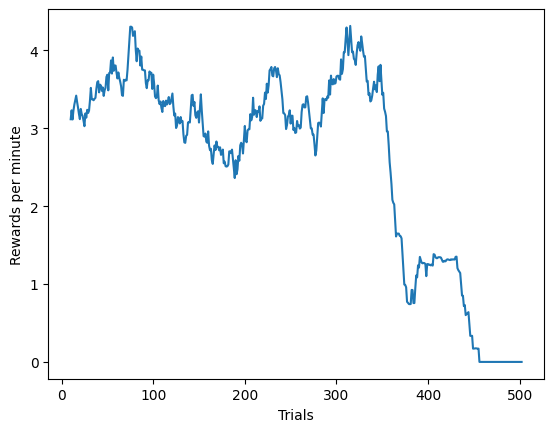

In [22]:
fig, ax = plt.subplots()

rolling_performance = behavior_session.get_rolling_performance_df()

ax.plot(rolling_performance['reward_rate'])
ax.set_ylabel('Rewards per minute')
ax.set_xlabel('Trials')

Looks like the mouse lost motivation around trial 350. Let's recompute our image-wise hit rates using only engaged trials. We'll define this as trials for which the reward rate was > 2 rewards per minute.

In [23]:
engaged_trials = trials[rolling_performance['reward_rate']>2]

hit_miss_table_engaged = engaged_trials.pivot_table(index='change_image_name', values=['hit', 'miss'], aggfunc=sum)
hit_miss_table_engaged['hit_rate'] = hit_miss_table_engaged['hit']/(hit_miss_table_engaged['hit'] + hit_miss_table_engaged['miss'])
hit_miss_table_engaged

hit  miss  hit_rate
change_image_name                     
im012_r             15    12  0.555556
im036_r              6    20  0.230769
im044_r             20     6  0.769231
im047_r             18     9  0.666667
im078_r             20     6  0.769231
im083_r              4    22  0.153846
im111_r             19     9  0.678571
im115_r             24     3  0.888889